# Plot number of search results for different microscopic locomotion models on https://scholar.google.com/

Use a stacked bar graph to show the effect the search term "pedestrian" vs. "crowd".

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def use_custom_plot_settings(font_weight="normal"):
    font_size_extra_small = 12
    font_size_small = 16
    font_size_medium = 18
    font_size_big = 20

    plt.style.use("default")
    
    plt.rc("font", size=font_size_small, weight=font_weight)
    plt.rc("axes", titlesize=font_size_big, titleweight=font_weight)
    plt.rc("axes", labelsize=font_size_medium, labelweight=font_weight)
    plt.rc("xtick", labelsize=font_size_small)
    plt.rc("ytick", labelsize=font_size_small)
    plt.rc("legend", fontsize=font_size_extra_small)
    plt.rc("figure", titlesize=font_size_big, titleweight=font_weight)

def use_default_plot_settings():
    plt.rcdefaults()
    
use_custom_plot_settings(font_weight="normal")
print(plt.style.available)

['seaborn-poster', 'seaborn-dark', 'seaborn-colorblind', 'seaborn-notebook', 'seaborn-darkgrid', 'Solarize_Light2', 'grayscale', '_classic_test', 'bmh', 'seaborn-deep', 'tableau-colorblind10', 'fast', 'seaborn', 'seaborn-pastel', 'seaborn-muted', 'seaborn-ticks', 'dark_background', 'seaborn-bright', 'classic', 'seaborn-talk', 'seaborn-white', 'ggplot', 'seaborn-paper', 'seaborn-dark-palette', 'seaborn-whitegrid', 'fivethirtyeight']


## Data Acquisition

In [3]:
import re
import requests

from bs4 import BeautifulSoup
from time import sleep

def get_search_results_from_google_scholar(search_term, sleep_time=0):
    # Google interprets plus signs as space.
    escaped_search_term = search_term.replace(" ", "+")
    
    url_without_search_query = 'https://scholar.google.com/scholar?hl=en&q={}'
    url_with_search_query = url_without_search_query.format(escaped_search_term)
    headers = { 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9' }
    
    response = requests.get(url_with_search_query, headers=headers)
    soup_wrapper = BeautifulSoup(response.content, "lxml")
                                 
    # Sleep for specific amount of time to avoid that we get banned by Google because of too much queries in a certain time.
    sleep(sleep_time)
    
    return str(soup_wrapper)

def extract_number_of_search_results(search_result_html_string):
    # Google's result line looks like this: "About 8.600 results (0,03 sec)"
    # And are wrapped into a HTML div container.
    # Use a regex group to match the total number of search results.
    regex_pattern = "<div.*>(.+) result.*</div>"
    regex_result = re.search(regex_pattern, search_result_html_string)
    
    if regex_result is None:
        raise Exception("String does not contain following regex pattern: {}".format(regex_pattern))

    # Replace optional "About" prefix and thousand separator(s)
    regex_group = regex_result.group(1)
    cleaned_search_result = regex_group.replace("About", "").replace(".", "")

    return int(cleaned_search_result)

search_term = "\"social force model\" pedestrian"
search_result_html_string = get_search_results_from_google_scholar(search_term)
total_search_results = extract_number_of_search_results(search_result_html_string)

print("Search term: {}".format(search_term))
print("Results: {}".format(total_search_results))

Search term: "social force model" pedestrian
Results: 7690


In [4]:
model_search_terms = ["cellular automaton", "social force model", "reynolds steering", "optimal reciprocal collision avoidance", "optimal steps model", "gradient navigation model", "behavioral heuristics model"]
crowd_search_terms = ["pedestrian", "crowd"]

# Create a data frame with two columns: pedestrian, crowd
# Each row contains the number of search results for a particular model
search_results_per_model = {
    crowd_search_terms[0]: [],
    crowd_search_terms[1]: [],
}

for crowd_search_term in crowd_search_terms:
    for model_search_term in model_search_terms:
        # Search for exact word order of the model by enclosing it in double quotes.
        search_term = "\"" + model_search_term + "\"" + " " + crowd_search_term
        
        search_result_html_string = get_search_results_from_google_scholar(search_term, sleep_time=0.1)
        total_search_results = extract_number_of_search_results(search_result_html_string)
        
        search_results_per_model[crowd_search_term].append(total_search_results)
        
df = pd.DataFrame(
    search_results_per_model,
    index=model_search_terms
)

df

,pedestrian,crowd
cellular automaton,6150,6040
social force model,7690,6870
reynolds steering,277,351
optimal reciprocal collision avoidance,313,311
optimal steps model,87,73
gradient navigation model,63,61
behavioral heuristics model,6,6


## Plots

\begin{tabular}{lrr}
\toprule
{} &  pedestrian &  crowd \\
\midrule
cellular automaton                     &        6150 &   6040 \\
social force model                     &        7690 &   6870 \\
reynolds steering                      &         277 &    351 \\
optimal reciprocal collision avoidance &         313 &    311 \\
optimal steps model                    &          87 &     73 \\
gradient navigation model              &          63 &     61 \\
behavioral heuristics model            &           6 &      6 \\
\bottomrule
\end{tabular}



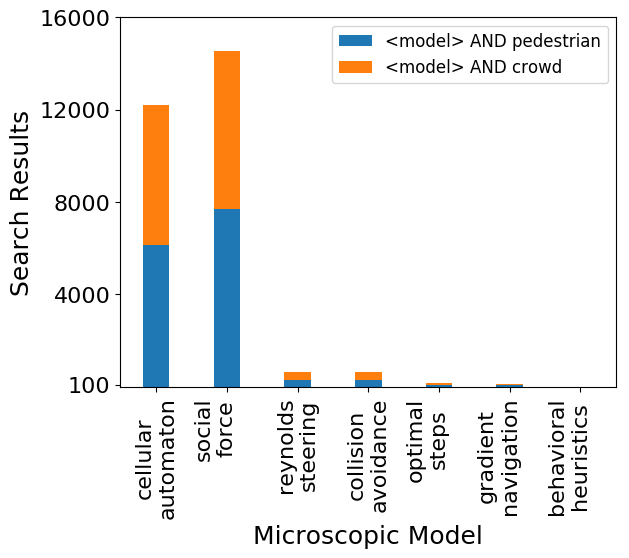

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

total_groups = len(df.index)
xpositions_for_bars = np.arange(0, total_groups * 4, 4)
bar_width = 1.5

for col_idx, col_name in enumerate(df.columns):
    col_data = df.iloc[:, col_idx]
    label_template = "<model> AND {}"
    
    if col_idx == 0:
        ax.bar(xpositions_for_bars, col_data, bar_width, label=label_template.format(col_name))
    else:
        previous_col_data = df.iloc[:, col_idx - 1]
        ax.bar(xpositions_for_bars, col_data, bar_width, label=label_template.format(col_name), bottom=previous_col_data)

# ax.set_title("Search results by locomotion model\non https://scholar.google.com/\nand search term variation")

ax.set_xlabel("Microscopic Model")
ax.set_xticks(xpositions_for_bars)
labels = [name.replace("model", "").replace(" ", "\n") for name in df.index]
labels = [name.replace("optimal\nreciprocal\ncollision\navoidance", "collision\navoidance") for name in labels]
ax.set_xticklabels(labels=labels, rotation=90)

ax.set_yticks([100, 4000, 8000, 12000, 16000])
ax.set_ylabel("Search Results")

ax.legend()

print(df.to_latex())
fig.savefig("LocomotionModels-SearchResults-GoogleScholar.pdf", bbox_inches="tight", transparent=True)
plt.show()